In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score

from PIL import Image
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset


## CNN Family Mushroom

### Dataset

In [71]:
path = "C:/Users/mbrei/OneDrive/Bureau/M2/ChampIA/Data/data_image"

We create a class to get the path of each image according to family and data type to transform it in tensors


In [ ]:
class MushroomDataset(Dataset):
        def __init__(self, root_dir, data_type, transform=None, percentage=100):
                """
                Choisir un répertoire racine et une transformation à appliquer aux images
                """
                self.root_dir = root_dir
                self.data_type = data_type 
                self.transform = transform
                self.percentage = percentage
                self.data = []
                self.classes = {}
                self.families = {}
                self.type_mapping = self.family_to_type()
                self._load_images()
                self._apply_percentage()
                
        def _load_images(self):
                """
                Récupérer les chemins de chaque image via différents dossiers avec l'étiquette de la famille de champignons
                """
                class_idx = 0
                family_idx= 0
                for family_name in os.listdir(self.root_dir):
                        family_dir = os.path.join(self.root_dir, family_name)
                        if os.path.isdir(family_dir):
                                data_type_dir = os.path.join(family_dir, 'data', self.data_type, family_name).replace('\\', '/')
                                data_type_dir_champ = os.path.join(family_dir, 'data', self.data_type, f"mushrooms {family_name}").replace('\\', '/')
                                if os.path.exists(data_type_dir):
                                        target_dir = data_type_dir
                                elif os.path.exists(data_type_dir_champ):
                                        target_dir = data_type_dir_champ
                                else:
                                        continue
                                # Gère les types
                                family_type = self.type_mapping.get(family_name.lower(), family_name.lower())
                                if family_type not in self.classes:
                                        self.classes[family_type] = class_idx
                                        class_idx += 1

                                # Gère les familles
                                if family_name not in self.families:
                                        self.families[family_name] = family_idx
                                        family_idx += 1

                                for img_file in os.listdir(target_dir):
                                        img_path = os.path.join(target_dir, img_file).replace('\\', '/')
                                        if img_file.lower().endswith(('.jpg')):
                                                self.data.append((img_path, family_name, family_type))
                                                
        def _apply_percentage(self):
                """ 
                Réduit les données selon le pourcentage spécifié 
                """
                if self.percentage < 100:
                        random.shuffle(self.data)
                        num_samples = int(len(self.data) * (self.percentage / 100))
                        self.data = self.data[:num_samples]
                                                        
        def family_to_type(self):
                """
                Dictionnaire des correspondances entre famille et type
                """
                correspondance = {
                'agaric': 'agaricales',
                'agaricus': 'agaricales',
                'amanita': 'agaricales',
                'bolete': 'boletales',
                'boletus': 'boletales',
                'cortinarius': 'agaricales',
                'entoloma': 'agaricales',
                'hygrocybe': 'agaricales',
                'lactarius': 'russulales',
                'russula': 'russulales',
                'suillus': 'boletales',
                'earthstar': 'geastrales',
                'stinkhorn': 'phallales',
                'hen_wood': 'polyporales',
                }
                
                return correspondance
                
        
        def __len__(self):
                """
                Nombre d'images aux globales
                """
                return len(self.data)

        
        def __getitem__(self, idx):
                img_path, family_name, family_type = self.data[idx]
                image = Image.open(img_path).convert("RGB")
                
                if self.transform:
                        image = self.transform(image)
                
                label = self.classes[family_type]
                family_label = self.families[family_name]
                
                return image, label, family_label

### Train/Test/Val

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Redimensionner les images
    transforms.ToTensor()      # Convertir en Tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation d'imagenet
])

train_data = MushroomDataset(root_dir=path, data_type='train', transform=transform)
test_data = MushroomDataset(root_dir=path, data_type='test', transform=transform)
val_data = MushroomDataset(root_dir=path, data_type='val', transform=transform)

In [140]:
test_data.get_class_distribution(by_family=False)

{'agaricales': 372,
 'boletales': 278,
 'russulales': 261,
 'geastrales': 124,
 'phallales': 141,
 'polyporales': 139}

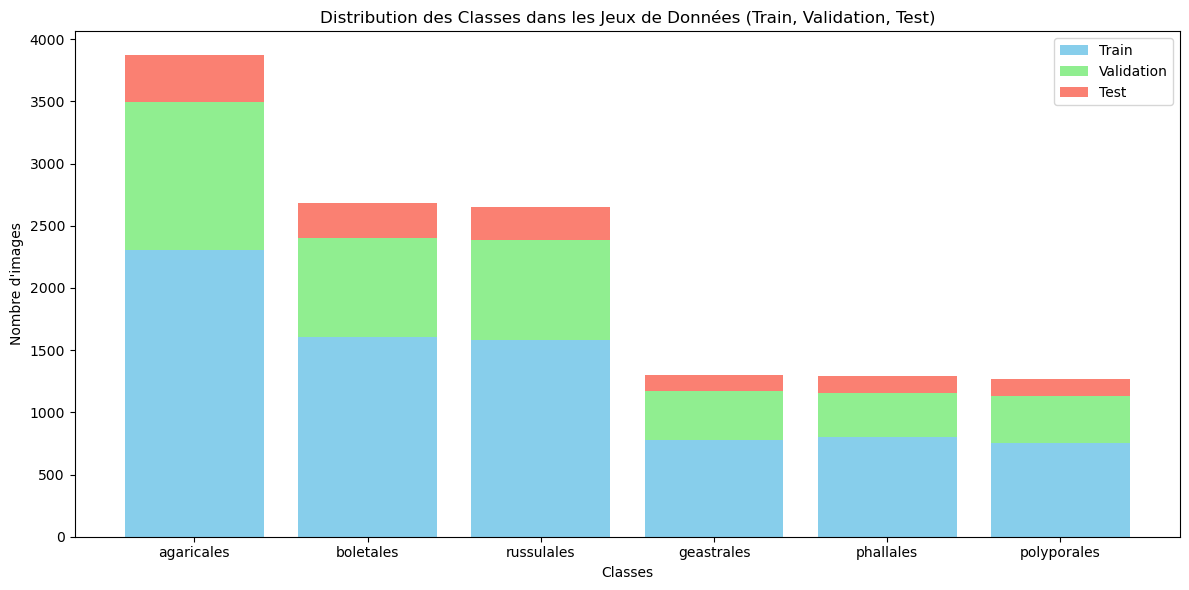

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer les distributions des classes pour chaque jeu de données
train_dist = get_class_distribution_dict(train_data)
val_dist = get_class_distribution_dict(val_data)
test_dist = get_class_distribution_dict(test_data)

# Extraire les classes (les mêmes pour tous les jeux de données)
classes = list(train_dist.keys())

# Créer les valeurs des distributions pour chaque jeu de données
train_counts = [train_dist[class_] for class_ in classes]
val_counts = [val_dist[class_] for class_ in classes]
test_counts = [test_dist[class_] for class_ in classes]

# Convertir les distributions en arrays numpy pour plus de facilité
train_counts = np.array(train_counts)
val_counts = np.array(val_counts)
test_counts = np.array(test_counts)

# Création du graphique avec des barres empilées
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(classes, train_counts, label="Train", color='skyblue')
ax.bar(classes, val_counts, bottom=train_counts, label="Validation", color='lightgreen')
ax.bar(classes, test_counts, bottom=train_counts+val_counts, label="Test", color='salmon')

# Ajouter des légendes et labels
ax.set_xlabel('Classes')
ax.set_ylabel('Nombre d\'images')
ax.set_title('Distribution des Classes dans les Jeux de Données (Train, Validation, Test)')
ax.legend()

# Rotation des labels des classes pour plus de lisibilité

# Ajuster l'affichage
plt.tight_layout()
plt.show()


In [158]:
train_data_33 = MushroomDataset(root_dir=path, data_type='train', transform=transform, percentage=33)
test_data_33 = MushroomDataset(root_dir=path, data_type='test', transform=transform, percentage=33)
val_data_33 = MushroomDataset(root_dir=path, data_type='val', transform=transform, percentage=33)

train_data_66 = MushroomDataset(root_dir=path, data_type='train', transform=transform, percentage=66)
test_data_66 = MushroomDataset(root_dir=path, data_type='test', transform=transform, percentage=66)
val_data_66 = MushroomDataset(root_dir=path, data_type='val', transform=transform, percentage=66)

In [159]:
train_data_33.get_class_distribution()

{'agaric': 1305, 'bolete': 510, 'earthstar': 246, 'stinkhorn': 270}

In [41]:
image, label, _ = train_data.__getitem__(1)
print(image)

tensor([[[ 0.6734,  1.0673,  1.3584,  ..., -0.2684, -0.5082, -0.7137],
         [ 1.1358,  1.2899,  1.7523,  ..., -0.1143, -0.6109, -0.7993],
         [ 1.0673,  1.6838,  1.7523,  ..., -0.0458, -0.6794, -0.9192],
         ...,
         [-1.7240, -1.8953, -2.0323,  ..., -0.6965, -0.5424, -0.6281],
         [-1.7240, -1.5870, -1.8097,  ..., -0.3541, -0.5596, -0.5253],
         [-1.5699, -1.5699, -1.9124,  ..., -0.5938, -0.5596, -0.6794]],

        [[ 1.0630,  1.5007,  1.8158,  ..., -0.5826, -0.7577, -0.8803],
         [ 1.4657,  1.6758,  2.2535,  ..., -0.4251, -0.8978, -1.0203],
         [ 1.2556,  2.0259,  2.2885,  ..., -0.3901, -1.0203, -1.2304],
         ...,
         [-1.7206, -1.8256, -1.9307,  ..., -1.0553, -0.9503, -1.1779],
         [-1.6856, -1.5105, -1.6856,  ..., -0.7752, -0.8978, -0.8627],
         [-1.5280, -1.4930, -1.7906,  ..., -1.1078, -0.8452, -0.8452]],

        [[ 1.7511,  1.9951,  2.1694,  ..., -0.7413, -0.8981, -1.0550],
         [ 2.1520,  2.1694,  2.5703,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


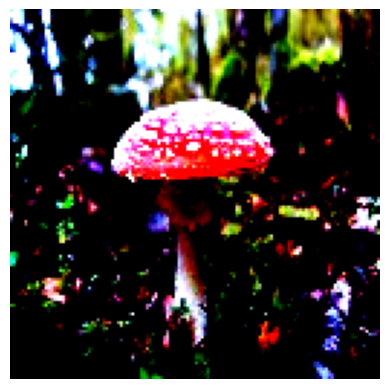

In [112]:
image, label, _ = train_data.__getitem__(1)
image.shape, label

plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

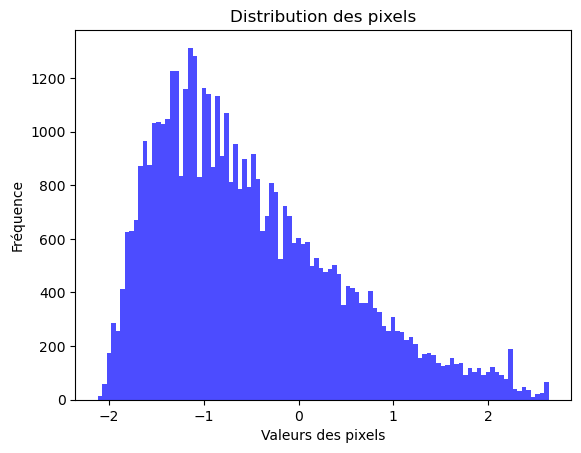

In [113]:
flattened = image.flatten()

# Calculer l'histogramme
plt.hist(flattened.numpy(), bins=100, color='blue', alpha=0.7)
plt.title("Distribution des pixels")
plt.xlabel("Valeurs des pixels")
plt.ylabel("Fréquence")
plt.show()

### Dataloader

In [115]:
BATCH_SIZE = 8
a_relu = 0.001
b_relu = 0.1
drop_value = 0.3


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [61]:
for images, labels, _ in train_loader:
    print(images.shape)  # Doit afficher torch.Size([batch_size, 3, 64, 64])
    print(labels.shape)  # Doit afficher torch.Size([batch_size])
    break

torch.Size([8, 3, 128, 128])
torch.Size([8])


### CNN

#### basicCNN

In [ ]:
import torch.nn as nn
import torch.optim as optim

class BaseCNN(nn.Module):

        def __init__(self, num_classes):
            super(BaseCNN, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
            self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)

            self.relu = nn.ReLU()
            
            self.pool = nn.MaxPool2d(2, 2)
            
            self.fc1 = nn.Linear(64*4*4, 64)
            self.fc3 = nn.Linear(64, num_classes)
            
        def forward(self, x):
            x = self.relu(self.conv1(x))
            x = self.pool(x)
            
            x = self.relu(self.conv2(x))
            x = self.pool(x)
            
            x = self.relu(self.conv3(x))
            x = self.pool(x)
            
            x = self.relu(self.conv4(x))
            x = self.pool(x)
            
            x = self.relu(self.conv5(x))
            x = self.pool(x)
            
            x = torch.flatten(x, 1)
            
            x = self.relu(self.fc1(x))
                        
            x = self.fc3(x)
            
            return x

#### Avec pooling

In [116]:
import torch.nn as nn
import torch.optim as optim

class PoolCNN(nn.Module):

        def __init__(self, num_classes):
            super(PoolCNN, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
            self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)
            
            #self.leaky_relu = nn.LeakyReLU(negative_slope=a_relu)
            #self.leaky_relu2 = nn.LeakyReLU(negative_slope=b_relu)
            self.relu = nn.ReLU()
            self.prelu1 = nn.PReLU()
            self.prelu2 = nn.PReLU()
            self.prelu3 = nn.PReLU()
            
            self.pool = nn.MaxPool2d(2, 2)
            
            self.dropout = nn.Dropout(p=drop_value)
            
            self.bn1 = nn.BatchNorm2d(8)
            self.bn2 = nn.BatchNorm2d(16)
            self.bn3 = nn.BatchNorm2d(32)
            self.bn4 = nn.BatchNorm2d(48)
            self.bn5 = nn.BatchNorm2d(64)
            
            self.fc1 = nn.Linear(64*4*4, 64)
            #self.fc2 = nn.Linear(64, 16)
            self.fc3 = nn.Linear(64, num_classes)
            
        def forward(self, x):
            x = self.relu(self.bn1(self.conv1(x)))
            x = self.pool(x)
            
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.pool(x)
            
            x = self.relu(self.bn3(self.conv3(x)))
            x = self.pool(x)
            
            x = self.prelu1(self.bn4(self.conv4(x)))
            x = self.pool(x)
            
            x = self.prelu2(self.bn5(self.conv5(x)))
            x = self.pool(x)
            
            x = torch.flatten(x, 1)
            
            x = self.prelu3(self.fc1(x))
            x = self.dropout(x)
            
            #x = self.leaky_relu(self.fc2(x))
            
            x = self.fc3(x)
            
            return x

#### Model

In [117]:
LR = 0.001
EPOCH = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
num_classes = len(train_data.classes)
model = PoolCNN(num_classes=num_classes)
hparams = {'lr': LR, 'batch_size': BATCH_SIZE, 'optimizer': 'Adam'}

In [119]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PoolCNN                                  [8, 6]                    --
├─Conv2d: 1-1                            [8, 8, 128, 128]          224
├─BatchNorm2d: 1-2                       [8, 8, 128, 128]          16
├─ReLU: 1-3                              [8, 8, 128, 128]          --
├─MaxPool2d: 1-4                         [8, 8, 64, 64]            --
├─Conv2d: 1-5                            [8, 16, 64, 64]           1,168
├─BatchNorm2d: 1-6                       [8, 16, 64, 64]           32
├─ReLU: 1-7                              [8, 16, 64, 64]           --
├─MaxPool2d: 1-8                         [8, 16, 32, 32]           --
├─Conv2d: 1-9                            [8, 32, 32, 32]           4,640
├─BatchNorm2d: 1-10                      [8, 32, 32, 32]           64
├─ReLU: 1-11                             [8, 32, 32, 32]           --
├─MaxPool2d: 1-12                        [8, 32, 16, 16]           --
├─Conv2d

### Training

In [82]:
#python -m tensorboard.main --logdir=Code/best_model

In [120]:
from torch.utils.tensorboard import SummaryWriter
import torchvision

from datetime import datetime   
run_name = f"5conv_5pool_BN_2fc_{LR}LR_{BATCH_SIZE}BATCH_{drop_value}regul_3prelu"  #{datetime.now().strftime('%d_%m_%Y-%H_%M')}
writer = SummaryWriter(f"best_cnn/{run_name}")

# images, labels, _= next(iter(train_loader))
# img_grid = torchvision.utils.make_grid(images[:12].cpu(), nrow=4, normalize=True)
# writer.add_image("Exemple d'images", img_grid, 0)
#writer.add_graph(model, images.to(DEVICE))

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
model.to(DEVICE)

best_train_acc = 0.0
best_val_acc = 0.0
best_model_wts = None


for epoch in range(EPOCH):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(all_labels, all_predictions, average="weighted")

    # Phase de validation
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / len(val_loader)
    scheduler.step(val_epoch_loss)

    val_epoch_acc = 100 * val_correct / val_total
    val_epoch_f1 = f1_score(val_labels, val_predictions, average="weighted")

    # Mettre à jour les meilleures accuracy
    if epoch_acc > best_train_acc:
        best_train_acc = epoch_acc

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = model.state_dict()

    # Affichage des métriques
    print(f"Epoch {epoch+1}/{EPOCH} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} | ")
    
    # Enregistrement dans TensorBoard
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Accuracy/train", epoch_acc, epoch)
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    writer.add_scalar("Accuracy/val", val_epoch_acc, epoch)
    writer.add_scalar("F1 Score/train", epoch_f1, epoch)
    writer.add_scalar("F1 Score/val", val_epoch_f1, epoch)

    
    # Poids des convolutions
    for name, weight in model.named_parameters():
        if "conv" in name and weight.dim() == 4:
            writer.add_histogram(f"Poids/{name}", weight, epoch)
            
    # Poids des couches fully connected (matrices de poids)
    for name, weight in model.named_parameters():
        if "fc" in name and weight.dim() == 2:  
            writer.add_histogram(f"Poids/{name}", weight, epoch)
    
    
from sklearn.metrics import f1_score

def test_metrics(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Stocker les prédictions et les labels pour le F1 Score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calcul des métriques
    accuracy_test = 100 * correct / total
    f1_test = f1_score(all_labels, all_predictions, average='weighted')*100  # 'weighted' pour la multi-classe

    return accuracy_test, f1_test

model.load_state_dict(best_model_wts)
accuracy_test, f1_test = test_metrics(model, test_loader, DEVICE)


description = f"""
# Description du modèle :

## Paramètres :
- Learning Rate : {LR}
- Batch Size : {BATCH_SIZE}
- Optimiseur : {optimizer}

## Meilleures Performances :
- Best Train Accuracy : {best_train_acc:.4f}%
- Best Validation Accuracy : {best_val_acc:.4f}%
- Accuracy on test data of best model: {accuracy_test:.2f}%
- F1 on test data of best model: {f1_test:.2f}%

## Architecture du modèle :
{summary(model, input_size=(BATCH_SIZE, 3, 128, 128))}
"""

writer.add_text("Documentation du modèle :", description)
    
writer.close()
 

Epoch 1/30 - Loss: 1.4413 - Acc: 42.7201 | Val Loss: 1.3641 - Val Acc: 47.0125 | 
Epoch 2/30 - Loss: 1.2403 - Acc: 52.0983 | Val Loss: 1.2268 - Val Acc: 53.9537 | 
Epoch 3/30 - Loss: 1.1547 - Acc: 55.9237 | Val Loss: 1.1560 - Val Acc: 55.7844 | 
Epoch 4/30 - Loss: 1.0874 - Acc: 58.6361 | Val Loss: 1.1432 - Val Acc: 54.8945 | 
Epoch 5/30 - Loss: 1.0187 - Acc: 61.8219 | Val Loss: 1.0715 - Val Acc: 59.4203 | 
Epoch 6/30 - Loss: 0.9655 - Acc: 63.6643 | Val Loss: 1.1409 - Val Acc: 57.0303 | 
Epoch 7/30 - Loss: 0.9153 - Acc: 65.6602 | Val Loss: 1.0486 - Val Acc: 61.0984 | 
Epoch 8/30 - Loss: 0.8544 - Acc: 68.0783 | Val Loss: 1.0360 - Val Acc: 61.5306 | 
Epoch 9/30 - Loss: 0.8089 - Acc: 69.6776 | Val Loss: 1.0629 - Val Acc: 60.9967 | 
Epoch 10/30 - Loss: 0.7386 - Acc: 72.8122 | Val Loss: 1.0441 - Val Acc: 63.7681 | 
Epoch 11/30 - Loss: 0.6833 - Acc: 75.0128 | Val Loss: 1.1123 - Val Acc: 59.4457 | 
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch 12/30 - Loss: 0.6345 - Acc: 

## Xgboost

In [149]:
import torch.nn as nn
import torch.optim as optim

class xgb_CNN(nn.Module):

        def __init__(self, num_classes):
            super(xgb_CNN, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
            self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)
            
            #self.leaky_relu = nn.LeakyReLU(negative_slope=a_relu)
            #self.leaky_relu2 = nn.LeakyReLU(negative_slope=b_relu)
            self.relu = nn.ReLU()
            self.prelu1 = nn.PReLU()
            self.prelu2 = nn.PReLU()
            self.prelu3 = nn.PReLU()
            
            self.pool = nn.MaxPool2d(2, 2)
            
            self.dropout = nn.Dropout(p=drop_value)
            
            self.bn1 = nn.BatchNorm2d(8)
            self.bn2 = nn.BatchNorm2d(16)
            self.bn3 = nn.BatchNorm2d(32)
            self.bn4 = nn.BatchNorm2d(48)
            self.bn5 = nn.BatchNorm2d(64)
            
            self.fc1 = nn.Linear(64*4*4, 64)
            #self.fc2 = nn.Linear(64, 16)
            self.fc3 = nn.Linear(64, num_classes)
            
        def forward(self, x):
            x = self.relu(self.bn1(self.conv1(x)))
            x = self.pool(x)
            
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.pool(x)
            
            x = self.relu(self.bn3(self.conv3(x)))
            x = self.pool(x)
            
            x = self.prelu1(self.bn4(self.conv4(x)))
            x = self.pool(x)
            
            x = self.prelu2(self.bn5(self.conv5(x)))
            x = self.pool(x)
            
            feature_map = torch.flatten(x, 1)
            
            x = self.prelu3(self.fc1(feature_map))
            x = self.dropout(x)
            
            #x = self.leaky_relu(self.fc2(x))
            
            x = self.fc3(x)
            
            return x, feature_map

In [150]:
LR = 0.001
EPOCH = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(train_data.classes)
model_xgb = xgb_CNN(num_classes=num_classes)
hparams = {'lr': LR, 'batch_size': BATCH_SIZE, 'optimizer': 'Adam'}

from torchinfo import summary
summary(model_xgb, input_size=(BATCH_SIZE, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
xgb_CNN                                  [8, 6]                    --
├─Conv2d: 1-1                            [8, 8, 128, 128]          224
├─BatchNorm2d: 1-2                       [8, 8, 128, 128]          16
├─ReLU: 1-3                              [8, 8, 128, 128]          --
├─MaxPool2d: 1-4                         [8, 8, 64, 64]            --
├─Conv2d: 1-5                            [8, 16, 64, 64]           1,168
├─BatchNorm2d: 1-6                       [8, 16, 64, 64]           32
├─ReLU: 1-7                              [8, 16, 64, 64]           --
├─MaxPool2d: 1-8                         [8, 16, 32, 32]           --
├─Conv2d: 1-9                            [8, 32, 32, 32]           4,640
├─BatchNorm2d: 1-10                      [8, 32, 32, 32]           64
├─ReLU: 1-11                             [8, 32, 32, 32]           --
├─MaxPool2d: 1-12                        [8, 32, 16, 16]           --
├─Conv2d

In [151]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_xgb.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
model_xgb.to(DEVICE)

best_train_acc = 0.0
best_val_acc = 0.0
best_model_wts = None

for epoch in range(EPOCH):
    model_xgb.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs, _ = model_xgb(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(all_labels, all_predictions, average="weighted")

    # Phase de validation
    model_xgb.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs, _ = model_xgb(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / len(val_loader)
    scheduler.step(val_epoch_loss)

    val_epoch_acc = 100 * val_correct / val_total
    val_epoch_f1 = f1_score(val_labels, val_predictions, average="weighted")

    # Mettre à jour les meilleures accuracy
    if epoch_acc > best_train_acc:
        best_train_acc = epoch_acc

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = model_xgb.state_dict()

    # Affichage des métriques
    print(f"Epoch {epoch+1}/{EPOCH} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} | ")
    
model_xgb.load_state_dict(best_model_wts)
 

Epoch 1/30 - Loss: 1.4414 - Acc: 42.4130 | Val Loss: 1.2913 - Val Acc: 48.0295 | 
Epoch 2/30 - Loss: 1.2303 - Acc: 51.5609 | Val Loss: 1.2009 - Val Acc: 54.1571 | 
Epoch 3/30 - Loss: 1.1255 - Acc: 57.2288 | Val Loss: 1.1129 - Val Acc: 57.9456 | 
Epoch 4/30 - Loss: 1.0634 - Acc: 59.0839 | Val Loss: 1.1080 - Val Acc: 58.0473 | 
Epoch 5/30 - Loss: 1.0033 - Acc: 61.9243 | Val Loss: 1.2293 - Val Acc: 53.4452 | 
Epoch 6/30 - Loss: 0.9373 - Acc: 64.9565 | Val Loss: 1.1004 - Val Acc: 58.7592 | 
Epoch 7/30 - Loss: 0.8804 - Acc: 67.3362 | Val Loss: 1.0352 - Val Acc: 60.2848 | 
Epoch 8/30 - Loss: 0.8135 - Acc: 69.0379 | Val Loss: 1.1518 - Val Acc: 58.9626 | 
Epoch 9/30 - Loss: 0.7781 - Acc: 70.8802 | Val Loss: 1.0681 - Val Acc: 60.6916 | 
Epoch 10/30 - Loss: 0.7054 - Acc: 73.8997 | Val Loss: 0.9824 - Val Acc: 63.9207 | 
Epoch 11/30 - Loss: 0.6472 - Acc: 76.0107 | Val Loss: 1.0353 - Val Acc: 63.1070 | 
Epoch 12/30 - Loss: 0.5957 - Acc: 77.9171 | Val Loss: 1.0322 - Val Acc: 63.5139 | 
Epoch 13/30 -

<All keys matched successfully>

In [152]:
import torch
import pandas as pd

# Fonction pour extraire et exporter les features en CSV
def extract_features(model, dataloader, device):
    model.eval()  # Mettre le modèle en mode évaluation
    all_features = []
    all_labels = []

    with torch.no_grad():  # Désactiver le calcul des gradients pour économiser de la mémoire
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Passer les données à travers le modèle et obtenir les features
            _, features = model(inputs)

            # Ajouter les features et les labels à leurs listes respectives
            all_features.append(features.cpu().numpy())  # Transférer les features sur CPU et les convertir en numpy
            all_labels.append(labels.cpu().numpy())  # Transférer les labels sur CPU et les convertir en numpy

    # Convertir les listes en un tableau numpy
    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    # Convertir en DataFrame pour une exportation facile vers CSV
    features_df = pd.DataFrame(all_features)
    features_df['label'] = all_labels  # Ajouter la colonne des labels

    # Sauvegarder le DataFrame dans un fichier CSV
    #features_df.to_csv('features.csv', index=False)
    return features_df

# Appel de la fonction après l'entraînement ou lors de la validation


In [153]:
feature_train = extract_features(model_xgb, train_loader, DEVICE)
feature_val = extract_features(model_xgb, val_loader, DEVICE)
feature_test = extract_features(model_xgb, test_loader, DEVICE)

In [154]:
feature_test

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,-0.028864,0.341956,-0.133896,0.720467,0.156683,0.017770,0.187757,0.779581,0.328089,0.553698,...,0.071316,-0.251759,-0.186276,-0.324296,0.274303,-0.305777,-0.065726,-0.351528,0.339950,1
1,-0.193906,0.140872,-0.152741,-0.081715,-0.183367,0.041983,0.276244,0.161551,-0.227321,-0.133166,...,0.363595,1.110535,-0.183343,0.106855,0.609571,0.328792,-0.185435,-0.269057,0.506035,4
2,-0.099943,-0.375753,-0.071194,0.157862,-0.024416,-0.291923,0.093960,-0.007388,0.198338,1.237535,...,0.141437,1.616171,0.460355,0.711065,0.133174,0.311929,-0.114567,-0.285950,0.005230,4
3,-0.133307,-0.122549,-0.088237,0.106378,0.171653,-0.255344,0.627541,-0.397703,0.037654,0.545783,...,-0.075211,-0.080173,0.784488,-0.155161,0.999722,-0.321533,0.340945,0.442732,0.295381,0
4,-0.180989,-0.182764,-0.210039,-0.087575,-0.224147,0.112404,-0.269918,0.015648,-0.215834,-0.230304,...,0.644132,0.854175,0.323789,-0.053562,-0.128811,-0.058692,0.493876,-0.088239,0.003450,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,0.430632,0.226136,0.742899,0.145768,0.089141,0.765798,1.086866,-0.282463,-0.161142,-0.006042,...,-0.347536,-0.091741,0.209003,-0.160306,-0.101940,-0.387281,-0.057711,-0.354161,-0.101346,1
1311,0.003699,-0.154552,0.656901,0.084410,-0.043200,0.465829,1.480778,0.342053,0.459293,0.571469,...,-0.046167,-0.148044,0.289121,0.730620,0.045384,0.132502,-0.279149,0.346208,0.246656,0
1312,-0.127743,0.197072,-0.078738,-0.196934,-0.123432,0.211383,0.064593,-0.187804,0.199063,0.321922,...,0.044905,-0.226932,1.228690,-0.158061,-0.172445,-0.163950,-0.212973,-0.472010,-0.148123,0
1313,0.342122,0.917934,-0.000950,-0.372184,0.075408,0.428336,0.109863,-0.131574,0.320612,0.227619,...,0.002332,-0.184667,-0.188777,0.209207,-0.119953,0.210803,0.562000,-0.339067,-0.146717,0


In [155]:
feature_train.to_csv('./feature_cnn/feature_train.csv', index=False)
feature_val.to_csv('./feature_cnn/feature_val.csv', index=False)
feature_test.to_csv('./feature_cnn/feature_test.csv', index=False)

## HOG

### Visu

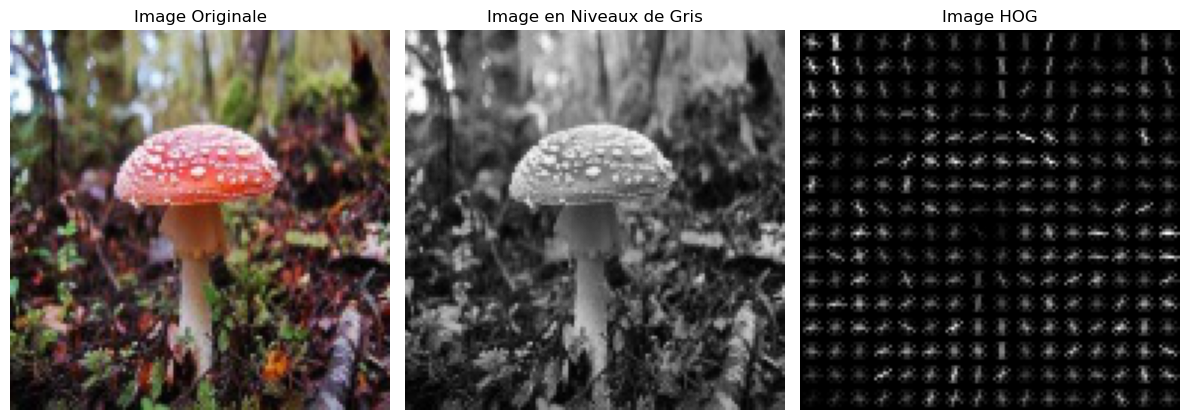

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
from PIL import Image

def visualize_hog(image_path):
    # 1. Charger l'image
    image = Image.open(image_path).convert("RGB")
    
    # 2. Convertir l'image en niveaux de gris
    gray_image = color.rgb2gray(np.array(image))

    # 3. Appliquer la transformation HOG
    hog_features, hog_image = hog(
        gray_image, 
        orientations=6, 
        pixels_per_cell=(4, 4), 
        cells_per_block=(3, 3), 
        block_norm='L2-Hys', 
        visualize=True
    )
    
    # 4. Visualiser l'image originale, l'image en niveaux de gris et les descripteurs HOG
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Image originale
    ax[0].imshow(image)
    ax[0].set_title("Image Originale")
    ax[0].axis('off')

    # Image en niveaux de gris
    ax[1].imshow(gray_image, cmap=plt.cm.gray)
    ax[1].set_title("Image en Niveaux de Gris")
    ax[1].axis('off')

    # Image descripteurs HOG
    ax[2].imshow(hog_image, cmap=plt.cm.gray)
    ax[2].set_title("Image HOG")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

# Tester la fonction avec une image
path = "C:/Users/mbrei/OneDrive/Bureau/M2/ChampIA/Data/data_image/agaric/data/train/agaric/01BZFJIN3WRY.jpg"
visualize_hog(path)


### Model

In [ ]:
from skimage.feature import hog
from skimage import color
import xgboost as xgb
from sklearn.metrics import accuracy_score

class MushroomDatasetWithHOG(MushroomDataset):
    def __getitem__(self, idx):
        img_path, family_name, family_type = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        image = color.rgb2gray(np.array(image))
        hog_features = hog(image, orientations=6, pixels_per_cell=(4, 4), 
                   cells_per_block=(3, 3), block_norm='L2-Hys')
        
        label = self.classes[family_type]
        family_label = self.families[family_name]
        
        return hog_features, label, family_label
    
def prepare_data_for_xgb(dataset):
    X = []
    y = []
    
    for hog_features, label, _ in dataset:
        X.append(hog_features)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [148]:
image

tensor([[[ 0.6734,  1.0673,  1.3584,  ..., -0.2684, -0.5082, -0.7137],
         [ 1.1358,  1.2899,  1.7523,  ..., -0.1143, -0.6109, -0.7993],
         [ 1.0673,  1.6838,  1.7523,  ..., -0.0458, -0.6794, -0.9192],
         ...,
         [-1.7240, -1.8953, -2.0323,  ..., -0.6965, -0.5424, -0.6281],
         [-1.7240, -1.5870, -1.8097,  ..., -0.3541, -0.5596, -0.5253],
         [-1.5699, -1.5699, -1.9124,  ..., -0.5938, -0.5596, -0.6794]],

        [[ 1.0630,  1.5007,  1.8158,  ..., -0.5826, -0.7577, -0.8803],
         [ 1.4657,  1.6758,  2.2535,  ..., -0.4251, -0.8978, -1.0203],
         [ 1.2556,  2.0259,  2.2885,  ..., -0.3901, -1.0203, -1.2304],
         ...,
         [-1.7206, -1.8256, -1.9307,  ..., -1.0553, -0.9503, -1.1779],
         [-1.6856, -1.5105, -1.6856,  ..., -0.7752, -0.8978, -0.8627],
         [-1.5280, -1.4930, -1.7906,  ..., -1.1078, -0.8452, -0.8452]],

        [[ 1.7511,  1.9951,  2.1694,  ..., -0.7413, -0.8981, -1.0550],
         [ 2.1520,  2.1694,  2.5703,  ..., -0

In [149]:
train_data_hog = MushroomDatasetWithHOG(root_dir=path, data_type='train')
test_data_hog = MushroomDatasetWithHOG(root_dir=path, data_type='test')
val_data_hog = MushroomDatasetWithHOG(root_dir=path, data_type='val')

In [37]:
image, label, _ = train_data_hog.__getitem__(1000)
print(image, label)

[0.20833225 0.18074665 0.0288578  ... 0.12074176 0.01709706 0.27026946] 0


In [150]:
X_train, y_train = prepare_data_for_xgb(train_data_hog)
X_val, y_val = prepare_data_for_xgb(val_data_hog)
X_test, y_test = prepare_data_for_xgb(test_data_hog)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'max_depth': 6, 
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'merror'
}

evallist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 100 
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)

c:\Users\mbrei\anaconda3\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [30]:
y_pred = bst.predict(dtest)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.379467680608365

## Pré-Entrainé

In [135]:
run_name = f"ResNet2_{LR}LR_{BATCH_SIZE}BATCH_avec_regul_0.1"  #{datetime.now().strftime('%d_%m_%Y-%H_%M')}
writer = SummaryWriter(f"best_cnn/{run_name}")

In [136]:
import torchvision.models as models

model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(train_data.classes)

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

model_resnet.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model_resnet.fc.in_features, num_classes)
)

In [137]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
model_resnet.to(DEVICE)

best_train_acc = 0.0
best_val_acc = 0.0
best_model_wts = None


for epoch in range(EPOCH):
    model_resnet.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(all_labels, all_predictions, average="weighted")

    # Phase de validation
    model_resnet.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / len(val_loader)
    scheduler.step(val_epoch_loss)

    val_epoch_acc = 100 * val_correct / val_total
    val_epoch_f1 = f1_score(val_labels, val_predictions, average="weighted")

    # Mettre à jour les meilleures accuracy
    if epoch_acc > best_train_acc:
        best_train_acc = epoch_acc

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = model_resnet.state_dict()

    # Affichage des métriques
    print(f"Epoch {epoch+1}/{EPOCH} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} | ")
    
    # Enregistrement dans TensorBoard
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Accuracy/train", epoch_acc, epoch)
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    writer.add_scalar("Accuracy/val", val_epoch_acc, epoch)
    writer.add_scalar("F1 Score/train", epoch_f1, epoch)
    writer.add_scalar("F1 Score/val", val_epoch_f1, epoch)
    
    
from sklearn.metrics import f1_score

def test_metrics(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels, _ = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Stocker les prédictions et les labels pour le F1 Score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calcul des métriques
    accuracy_test = 100 * correct / total
    f1_test = f1_score(all_labels, all_predictions, average='weighted')*100  # 'weighted' pour la multi-classe

    return accuracy_test, f1_test

model_resnet.load_state_dict(best_model_wts)
accuracy_test, f1_test = test_metrics(model_resnet, test_loader, DEVICE)


description = f"""
# Description du modèle :

## Paramètres :
- Learning Rate : {LR}
- Batch Size : {BATCH_SIZE}
- Optimiseur : {optimizer}

## Meilleures Performances :
- Best Train Accuracy : {best_train_acc:.4f}%
- Best Validation Accuracy : {best_val_acc:.4f}%
- Accuracy on test data of best model: {accuracy_test:.2f}%
- F1 on test data of best model: {f1_test:.2f}%

## Architecture du modèle :
{summary(model_resnet, input_size=(BATCH_SIZE, 3, 128, 128))}
"""

writer.add_text("Documentation du modèle :", description)
    
writer.close()
 

Epoch 1/30 - Loss: 1.3182 - Acc: 50.2815 | Val Loss: 1.2991 - Val Acc: 52.0468 | 
Epoch 2/30 - Loss: 1.0705 - Acc: 60.3378 | Val Loss: 0.9627 - Val Acc: 65.0648 | 
Epoch 3/30 - Loss: 0.9514 - Acc: 65.5578 | Val Loss: 0.9445 - Val Acc: 65.4462 | 
Epoch 4/30 - Loss: 0.8506 - Acc: 69.9207 | Val Loss: 0.8797 - Val Acc: 69.0058 | 
Epoch 5/30 - Loss: 0.7753 - Acc: 72.1469 | Val Loss: 0.8587 - Val Acc: 69.7686 | 
Epoch 6/30 - Loss: 0.6751 - Acc: 76.3690 | Val Loss: 0.9714 - Val Acc: 66.0819 | 
Epoch 7/30 - Loss: 0.5732 - Acc: 80.0665 | Val Loss: 0.8972 - Val Acc: 69.5906 | 
Epoch 8/30 - Loss: 0.4642 - Acc: 83.8280 | Val Loss: 0.9181 - Val Acc: 69.4635 | 
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch 9/30 - Loss: 0.3884 - Acc: 86.9115 | Val Loss: 1.0549 - Val Acc: 69.1076 | 
Epoch 10/30 - Loss: 0.1673 - Acc: 94.6520 | Val Loss: 1.0414 - Val Acc: 71.6501 | 
Epoch 11/30 - Loss: 0.1070 - Acc: 96.5328 | Val Loss: 1.2260 - Val Acc: 70.6331 | 
Epoch 12/30 - Loss: 0.1061 - Acc: 

KeyboardInterrupt: 

## Mushroom world image

In [5]:
path = 'C:/Users/mbrei/OneDrive/Bureau/M2/ChampIA/Data/mushroom_data.csv'

In [11]:
mush_world = pd.read_csv(path)
mush_world.head(2)

,url,scientific_name,common_name,family,location,dimension,edibility,description,image
0,https://www.mushroom.world/show?n=Agaricus-arv...,Agaricus arvensis\r\n (Horse Mushroom),Horse Mushroom,Agaricaceae,Europe and parts of North America and Asia,"Cap 8-20 cm diameter, stem 8-10 cm tall * 1.5-...",This site contains no information about the ed...,"Agaricus arvensis, commonly known as the horse...","/data/fungi/Agaricusarvensis1.jpg, /data/fungi..."
1,https://www.mushroom.world/show?n=Agaricus-aug...,Agaricus augustus\r\n (The Prince),The Prince,Agaricaceae,"Europe, Asia, northern Africa and many parts ...","Cap 10-20 cm diameter, stem 10-20 cm tall * 2-...",This site contains no information about the ed...,"Agaricus augustus, also known as The Prince, i...","/data/fungi/Agaricusaugustus1.jpg, /data/fungi..."


### Get Image

In [14]:
mush_world['image'].iloc[0]

'/data/fungi/Agaricusarvensis1.jpg, /data/fungi/Agaricusarvensis2.jpg, /data/fungi/Agaricusarvensis3.jpg, /data/fungi/Agaricusarvensis4.jpg, /data/fungi/Agaricusarvensis5.jpg, /data/fungi/Agaricusarvensis6.jpg, /data/fungi/Agaricusarvensis7.jpg'

In [ ]:
https://www.mushroom.world/data/fungi/Agaricusarvensis1-thumb.jpg